In [8]:
# from typing import List
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import seaborn as sns

# from sklearn.preprocessing import StandardScaler, RobustScaler, robust_scale
# from sklearn.impute import KNNImputer
# from sklearn.cluster import KMeans
# from sklearn.pipeline import make_pipeline
# from drn_interactions.io import load_derived_generic
# from drn_interactions.plots import heatmap
# from drn_interactions.config import Config
# from drn_interactions.io import load_derived_generic


In [7]:
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import robust_scale, scale
from sklearn.preprocessing import StandardScaler, RobustScaler, robust_scale
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from drn_interactions.io import load_derived_generic
from drn_interactions.plots import heatmap
from drn_interactions.config import Config

In [2]:
df_spiketrains = load_derived_generic("spiketrain_stats_segments.csv")
df_wavemap = load_derived_generic("wavemap.csv")
df_waveforms = load_derived_generic("waveform_summary.csv")


df = pd.merge(df_waveforms, df_spiketrains, on="neuron_id", how="outer")
df = pd.merge(df, df_wavemap, on="neuron_id", how="outer")

In [3]:
dft = df.copy()
dft["mean_firing_rate"] = np.select(
    condlist=[
        df["mean_firing_rate"] <= 0.5,
        df["mean_firing_rate"] >= 25,
    ], choicelist=[np.nan,np.nan],
    default=df["mean_firing_rate"]
)

dft["width_min"] = np.select(
    condlist=[
        df["width_min"] <= 10,
        df["width_min"] >= 25,
    ], choicelist=[np.nan, np.nan], default=df["width_min"]
)

dft["width_overall"] = np.select(
    condlist=[
        df["width_min"] <= 50,
        df["width_min"] >= 105,
    ], choicelist=[np.nan, np.nan], default=df["width_overall"]
)

c:\users\roryl\repos\drn interactions\drn_interactions\plots\heatmaps.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(formater_x)


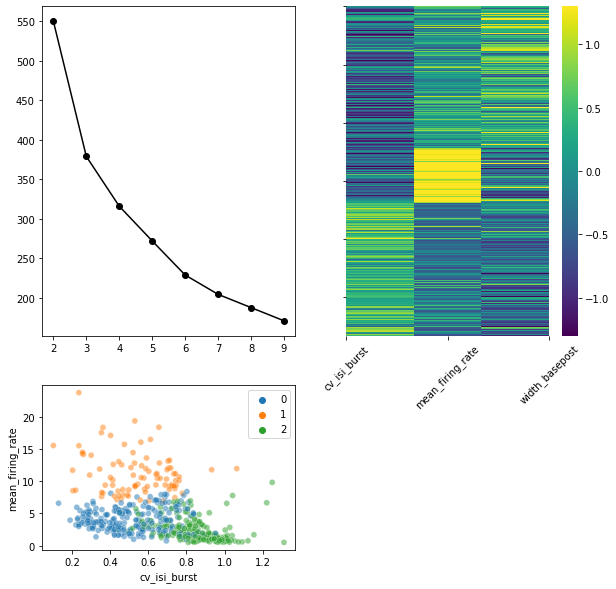

In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler

df_cluster = dft.copy()
cols = ["cv_isi_burst", "mean_firing_rate", "width_basepost"]
df_cluster = df_cluster


X = df_cluster[cols].values
imputer = KNNImputer(n_neighbors=5)

scaler2 = RobustScaler()

pipe = make_pipeline(scaler2, imputer)
X = pipe.fit_transform(X)
mod = KMeans(3, random_state=0)
preds = mod.fit_predict(X)


f = plt.figure(figsize=(10, 10))
gs = f.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 0.5])
ax = f.add_subplot(gs[0, 0])
n_clusters = list(range(2, 10))
error = [KMeans(i).fit(X).inertia_ for i in n_clusters]
_ = ax.plot(n_clusters, error, "ko-")

ax = f.add_subplot(gs[1, 0])
sns.scatterplot(x="cv_isi_burst", y="mean_firing_rate", hue=pd.Categorical(preds), data=df_cluster, ax=ax, alpha=0.5)

ax, cbar = heatmap(
    pd.DataFrame(X).iloc[np.argsort(preds),], 
    ax=f.add_subplot(gs[0, 1]),
    heatmap_kwargs=dict(cmap="viridis", center=0, vmin=-1.3, vmax=1.3,),
    locater_x=plt.LinearLocator(len(cols)),
    formater_x=plt.FixedFormatter(cols),
)
ax.tick_params(axis="x", which="major", rotation=45)

In [6]:
from drn_interactions.io import load_neurons
df_cluster["neuron_type"] = np.select(
    condlist = [preds == 0,  preds == 1, preds == 2,], 
    choicelist = ["SR", "FF", "SIR"], 
    default = "undetermined"
    )


In [9]:
neurons = load_neurons()[["neuron_id", "session_name", "group_name"]]
df_neuron_types = df_cluster.merge(neurons, how="outer")
df_neuron_types = df_neuron_types[["neuron_id", "neuron_type", "session_name", "group_name",]]
df_neuron_types.to_csv(Config.derived_data_dir / "neuron_types.csv", index=False)

<AxesSubplot:xlabel='cv-isi', ylabel='firing_rate'>

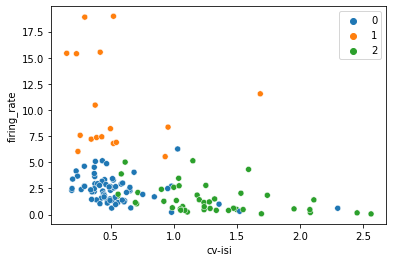

In [10]:
df_su = load_derived_generic("single_unit_dataset_tidied.csv").loc[lambda x: x["cv-isi"] < 3]

clf = DecisionTreeClassifier(max_depth=12)
pipe = make_pipeline(KNNImputer(), clf)

X_probe = df_cluster[["cv_isi_burst", "mean_firing_rate", "width_minpost"]].values

X_probe = scale(X_probe)
y_probe = preds

X_single_unit = df_su[["cv-isi", "firing_rate", "to_baseline"]].values
X_single_unit = scale(X_single_unit)

pipe.fit(X_probe, y_probe)
preds_su = pipe.predict(X_single_unit)
sns.scatterplot(data=df_su, x="cv-isi", y="firing_rate", hue=pd.Categorical(preds_su))

In [11]:
df_su["neuron_type"] = np.select(
    condlist = [preds_su == 0, preds_su == 1, preds_su == 2], 
    choicelist = ["SR", "FF", "SIR"], 
    default = "undetermined"
    )
df_su[["id", "neuron_type"]].to_csv(Config.derived_data_dir / "neuron_types_single_unit.csv", index=False)